# Imports

In [1]:
try:
  import iminuit
  from iminuit import Minuit
  from iminuit.cost import LeastSquares, UnbinnedNLL, BinnedNLL, ExtendedUnbinnedNLL
except:
  Exception('Error Initialising Iminuit')

In [2]:
import os
from IPython.display import Latex
import numpy as np
import scipy as sp
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

from funcs import *
from stats import *
from Fit import *

# Functions

In [3]:
def H_R(w,R,C):
    return w*R*C/np.sqrt(1+np.power(w*R*C,2))

def H_C(w,R,C):
    return 1/np.sqrt(1+np.power(w*R*C,2))

def fase_R(w,R,C):
    return np.arctan(1/(w*R*C))

def fase_C(w,R,C):
    return np.arctan(-w*R*C)

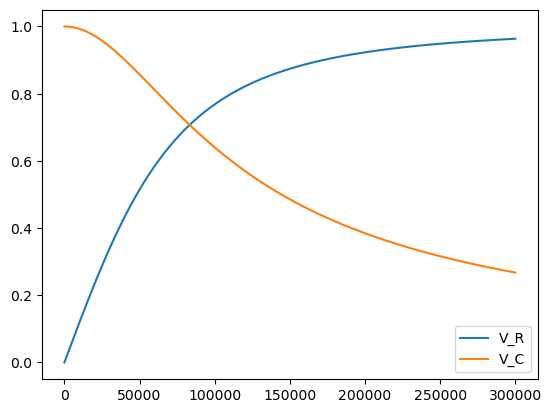

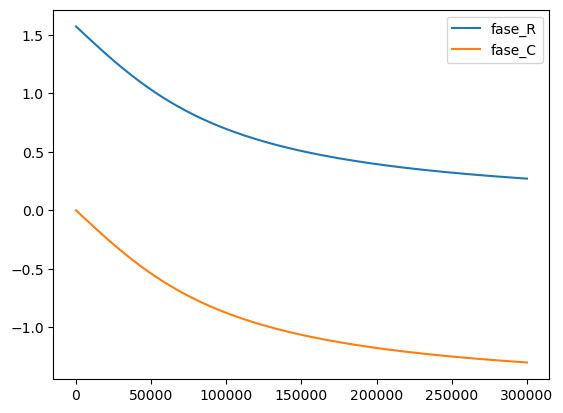

In [4]:
w = np.linspace(1,300e3,1000)
V_R_ = H_R(w,1e3,12e-9)
V_C_ = H_C(w,1e3,12e-9)
fase_R_ = fase_R(w,1e3,12e-9)
fase_C_ = fase_C(w,1e3,12e-9)

plt.plot(w,V_R_,label='V_R')
plt.plot(w,V_C_,label='V_C')
plt.legend()
plt.show()
plt.plot(w,fase_R_,label='fase_R')
plt.plot(w,fase_C_,label='fase_C')
plt.legend()
plt.show()

# RC

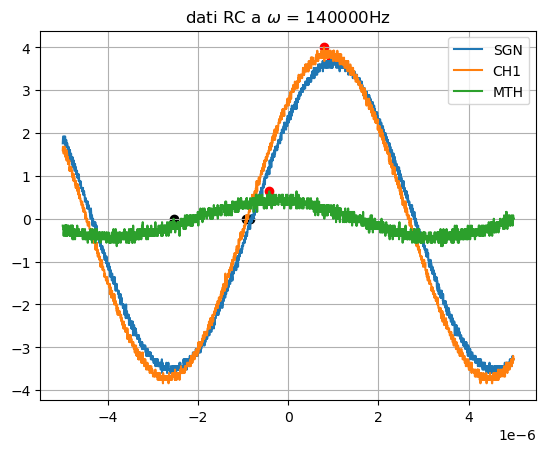

In [5]:
path = 'data/RC/140000/'
CH1,SGN,MTH, V_CH1_SGN, V_MTH_SGN, dt_CH1_SGN, dt_MTH_SGN, max_CH1, max_SGN, max_MTH, i_max_CH1, i_max_SGN, i_max_MTH, i_zero_CH1, i_zero_SGN, i_zero_MTH = analize(path, 200, True)

plt.plot(SGN[0], SGN[1], label='SGN')
plt.plot(CH1[0], CH1[1], label='CH1')
plt.plot(MTH[0], MTH[1], label='MTH')
plt.scatter(CH1[0][i_max_CH1], max_CH1, color='red')
plt.scatter(MTH[0][i_max_MTH], max_MTH, color='red')
plt.scatter(CH1[0][i_zero_CH1], CH1[0][i_zero_CH1], color='k')
plt.scatter(SGN[0][i_zero_SGN], SGN[0][i_zero_SGN], color='k')
plt.scatter(MTH[0][i_zero_MTH], MTH[0][i_zero_MTH], color='k')
plt.scatter(SGN[0][i_max_SGN], 3.76, color='r')
plt.title(r"dati RC a $\omega$ = 140000Hz")
plt.grid()
plt.legend()

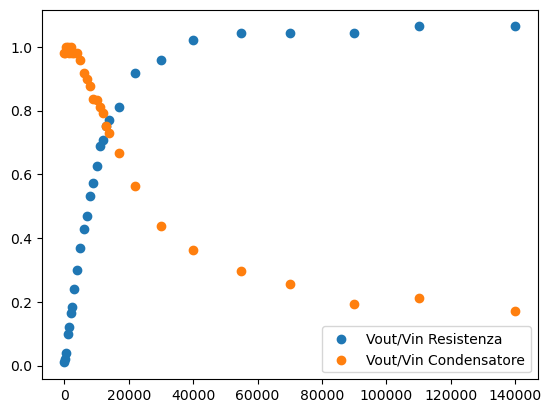

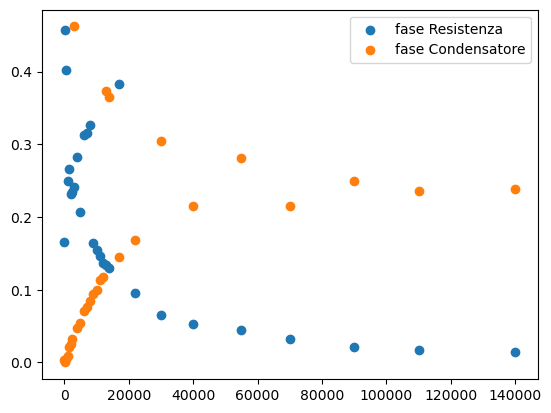

In [6]:
V_res_all, fase_res, freqs = [], [], []
V_c_all, fase_c = [], []

for i in os.listdir('data/RC'):
    path = 'data/RC/'+i+'/'
    V_CH1_RES, V_C_SGN, dt_RES_SGN, dt_C_SGN = analize(path, 300, False)
    V_res_all.append(V_CH1_RES)
    V_c_all.append(V_C_SGN)
    fase_res.append(np.abs(dt_RES_SGN*float(i)))
    fase_c.append(np.abs(dt_C_SGN*float(i)))
    freqs.append(float(i))

freqs = np.array(freqs)
V_res_all = np.array(V_res_all)
plt.scatter(freqs,V_res_all, label='Vout/Vin Resistenza')
plt.scatter(freqs,V_c_all, label='Vout/Vin Condensatore')
plt.legend()
plt.show()
plt.scatter(freqs, fase_res, label='fase Resistenza')
plt.scatter(freqs, fase_c, label='fase Condensatore')
plt.legend()
plt.show()

In [7]:
def H_R(w,tau, a):
    return w*tau/np.sqrt(1+(w**2 * tau**2)) + a

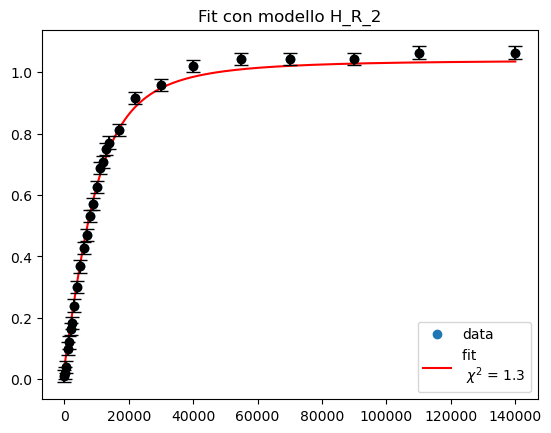

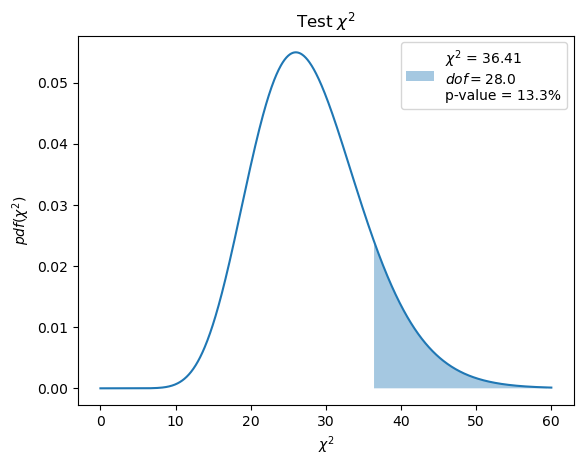

In [8]:
f = Fit(freqs, V_res_all, H_R, 0.02, kwargs={'tau':1e-3, 'a':0.07})
popt, pcov = f.fit(scipy=True)

f.fit(scipy=True)
fig, ax = f.visualize()
plt.legend()
plt.title('Fit con modello H_R_2')
plt.show()
chi_test(f.fval, f.ndof, 60)
plt.show()

In [9]:
def H_C(w,tau, a, b):
    return b/np.sqrt(1+(w**2 * tau**2)) + a

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


{'tau': -7.133252104683324e-05, 'a': 0.06887112364594124, 'b': 0.9292943552512793}
{'tau': 1.2130377711541032e-06, 'a': 0.006665183666616131, 'b': 0.0067056420516068}
Chi2 =  1.5481314451199188


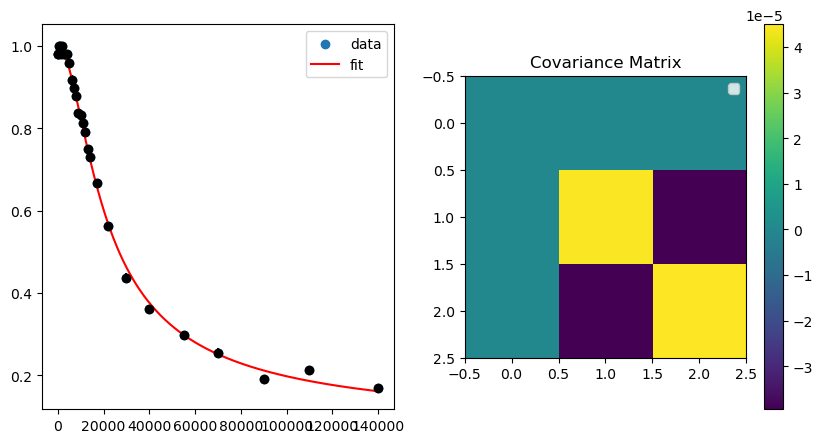

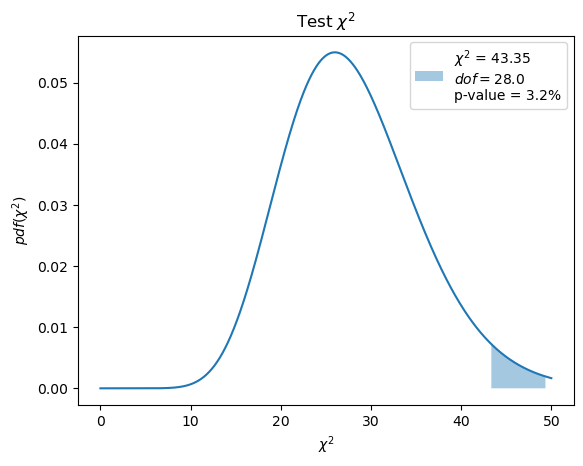

In [10]:
f = Fit(freqs, V_c_all, H_C, 0.01, kwargs={'tau':1e-3, 'a':0.07, 'b':1})
f.fit()
f.visualize(cov=True)
plt.legend()
print(f.values)
print(f.errors)
print("Chi2 = ",f.fval / f.ndof)
plt.show()
chi_test(f.fval, f.ndof, 50)
plt.show()

# RL

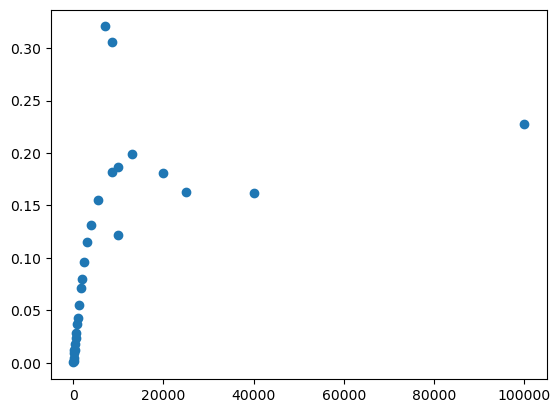

In [11]:
mods, fases, freqs = [], [], []

for i in os.listdir('data/RL'):
    path = 'data/RL/'+i+'/'
    V_res, V_c, dt_res, dt_c = analize(path, 1000)
    mods.append(V_res)
    fases.append(dt_res*float(i))
    freqs.append(int(i))

# plt.scatter(freqs,mods)
plt.scatter(freqs,fases)

In [12]:
N = 8501

3.74e-05 7.599999999999995e-06


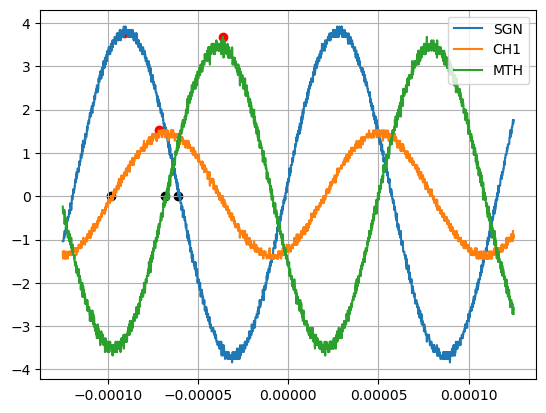

In [16]:
path = 'data/RL/'+str(N)+'/'
CH1,SGN,MTH, V_CH1_SGN, V_MTH_SGN, dt_CH1_SGN, dt_MTH_SGN, max_CH1, max_SGN, max_MTH, i_max_CH1, i_max_SGN, i_max_MTH, i_zero_CH1, i_zero_SGN, i_zero_MTH = analize(path, 200, True)
print(dt_CH1_SGN, dt_MTH_SGN)
plt.plot(SGN[0], SGN[1], label='SGN')
plt.plot(CH1[0], CH1[1], label='CH1')
plt.plot(MTH[0], MTH[1], label='MTH')
plt.scatter(CH1[0][i_max_CH1], max_CH1, color='red')
plt.scatter(MTH[0][i_max_MTH], max_MTH, color='red')
plt.scatter(CH1[0][i_zero_CH1], CH1[0][i_zero_CH1], color='k')
plt.scatter(SGN[0][i_zero_SGN], SGN[0][i_zero_SGN], color='k')
plt.scatter(MTH[0][i_zero_MTH], MTH[0][i_zero_MTH], color='k')
plt.scatter(SGN[0][i_max_SGN], 3.76, color='r')
plt.grid()
plt.legend()